In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
# !{sys.executable} -m pip install opencv-python matplotlib
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# !mkdir images
# !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
    
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P /lfs/turing3/0/kaif/checkpoints/

PyTorch version: 1.12.1
Torchvision version: 0.13.1
CUDA is available: True


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [340]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([0, 0, 0, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='purple', marker='*', s=marker_size, edgecolor='white', linewidth=0.5)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=0.5)   
    

In [248]:
from pathlib import Path
import os

root_dir = Path("/lfs/turing3/0/kaif/data/processed")
mask_root_dir = root_dir / "masks"
pre_root_dir = root_dir / "pre-scaled-fire-images"
post_root_dir = root_dir / "post-fire-images"

regions = [Path(f).stem for f in os.listdir(mask_root_dir)]

files_mask = {f: mask_root_dir / f'{f}.npy' for f in regions}
files_pre = {f: pre_root_dir / f'{f}.tif' for f in regions}
files_post = {f: post_root_dir / f'{f}.tif' for f in regions}
len(files_mask), len(files_pre), len(files_post), len(regions)

(1590, 1590, 1590, 1590)

In [287]:
import rasterio
import rioxarray
import xarray as xr

region = regions[1502]

ds = (
    xr.open_dataset(files_post[region])
    .to_array() # transform to an array rather than the xr.Dataset
    .squeeze()  # just like in numpy, remove all singletons
)
ds.rio.set_crs(4326)
ds.shape

(6, 110, 188)

In [306]:
import pdb
import os
import dask
import rioxarray
import numpy as np
import xarray as xr
import pandas as pd

import warnings
from itertools import combinations
from dask.diagnostics import ProgressBar


def apply_bitmask(arr) -> xr.DataArray or np.array:
    """Apply QA pixel bit mask for each array depending on platform"""

    unique_platform = np.unique(arr.platform.to_numpy())

    if ["landsat-8", "landsat-9"] in unique_platform:
        mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
    elif ["landsat-4", "landsat-5", "landsat-7"] in unique_platform:
        mask_bitfields = [1, 3, 4, 5]  # dilated cloud, cirrus, cloud, cloud shadow
    elif ["landsat-4", "landsat-5"] in unique_platform:
        mask_bitfields = [1, 3, 4, 5]  # dilated cloud, cirrus, cloud, cloud shadow
    else:
        raise ValueError(f"No bit mask defined for {arr.platform.to_numpy()}")

    bitmask = 0
    for field in mask_bitfields:
        bitmask |= 1 << field

    qa = arr.sel(band="qa_pixel").astype("uint16")
    bad = qa & bitmask  # just look at those 4 bits

    arr = arr.where(bad == 0)

    return arr


def calculate_nbr(data):
    """Calculate NBR in xarray DataArray

    Calculate the Normalized Burn Ratio for a DataArray with Landsat data. This
    function uses the NBR standard formula: .

    Args:
        - data (xr.DataArray): A data array with the "nir08" and the "swir16"
          bands.

    Returns:
        xr.DataArray
    """

    # Calculate NBR manually using the normal formula
    # nbr_manual = (
    #     data.sel(band="nir08").squeeze() - data.sel(band="swir16").squeeze()
    # ) / (data.sel(band="nir08").squeeze() + data.sel(band="swir16").squeeze())
    nbr_manual = (
        data[:, :, 4].squeeze() - data[:, :, 5].squeeze()
    ) / (data[:, :, 4].squeeze() + data[:, :, 5].squeeze())
    # print((data.sel(band="nir08").squeeze() + data.sel(band="swir16").squeeze()).compute())

    return nbr_manual


@dask.delayed
def apply_bit_mask_group(arr):
    """Apply QA mask to array across different platforms

    Apply the QA mask on xarray object using the platform variable. If the
    coordinate is not available, then an error will be raised! If the platform
    value is unique, then is only applied to the unique platform.

    Args:
        - arr (xr.Dataset or xr.DataArray)

    Returns:
        xr.Dataset or xr.DataArray
    """

    # Apply QA bitmask
    try:
        if len(arr['platform'].dims) == 0:
          arr = apply_bitmask(arr)
        else:
          arr = arr.groupby("platform").map(apply_bitmask)
    except TypeError or IndexError as e:
        print(f"Exception: {e}. Maybe platform length is zero: {arr.platform.values}")
        arr = apply_bitmask(arr)

    return arr


def calculate_dnbr(
    pre_data,
    post_data,
    apply_qa_bitmask=True,
    save=None,
) -> xr.DataArray:
    """Calculate dNBR for a specific even across timeline

    Following Parks (2019), we calculate the dNBR using two sets of images: one
    pre- and post-event. We calculate the NBR using the mean composite of both
    sets and then subtract the pre values from the post period. Since we want to
    compare events, we calculate an offset using the buffer. Then our dNBR for
    each pixel is:

        \[
        \DeltaNBR_{i} = NBR_{i, t=1} - NBR_{i, t=0} - NBR_{offset}
        \]

    Args:
        - pre_array (str): path to pre-array path for the event. If event_id is
          passed, then only the root path will be used.
        - post_array (str): path to post-array for the same event. If event_id
          is passed, then only the root path will be used
        - geometry (gpd.GeoDataFrame): Spatial dataframe object with event data.
          The function expect that event_id is identical.
        - buffer_offset_size (int): Buffer distance to build offset value. If
          None, then no offset will be calculated.
        - apply_qa_bitmask (bool): If `True` apply the bitmask and remove all
          bad pixels following the QA flags
        - event_id (str): Event ID to find images in pre and post imagery paths
          and in geometry.
        - save (str): A path to save the restulting array. If `None`, then it
          won't save it.

    Returns:
        xr.DataArray
    """

    if apply_qa_bitmask:
        pre_data = apply_bit_mask_group(pre_data)
        post_data = apply_bit_mask_group(post_data)

    # Calculate NBR for both periods
    pre_nbr = calculate_nbr(pre_data)
    post_nbr = calculate_nbr(post_data)

    # Calculate dNBR for all the pixels
    dnbr = pre_nbr - post_nbr

    if save is not None:
        dnbr.rio.to_raster(save, tiled=True, windowed=True)

    return dnbr.compute()

In [394]:
ROBUST_PERCENTILE = 2.0

def rescale_imshow_rgb(darray, vmin=None, vmax=None, robust=True, axis=-1):
    assert robust or vmin is not None or vmax is not None

    ndim = len(darray.shape)
    if axis < 0:
        axis = ndim + axis

    reduce_dim = list(range(ndim))
    reduce_dim.remove(axis)

    # Calculate vmin and vmax automatically for `robust=True`
    # Assume that the last dimension of the array represents color channels
    # Make sure to apply np.nanpercentile over this dimension by specifying axis=-1
    if robust:
        if vmax is None:
            vmax = np.nanpercentile(darray, 100 - ROBUST_PERCENTILE, axis=reduce_dim, keepdims=True)
        if vmin is None:
            vmin = np.nanpercentile(darray, ROBUST_PERCENTILE, axis=reduce_dim, keepdims=True)
    # If not robust and one bound is None, calculate the default other bound
    # and check that an interval between them exists.
    elif vmax is None:
        vmax = 255 if np.issubdtype(darray.dtype, np.integer) else 1
        if np.any(vmax < vmin):
            raise ValueError(
                f"vmin={vmin!r} less than the default vmax ({vmax!r}) - you must supply "
                "a vmax > vmin in this case."
            )
    elif vmin is None:
        vmin = 0
        if np.any(vmin > vmax):
            raise ValueError(
                f"vmax={vmax!r} is less than the default vmin (0) - you must supply "
                "a vmin < vmax in this case."
            )
    # Compute a mask for where vmax equals vmin
    vmax_equals_vmin = np.isclose(vmax, vmin)

    # Avoid division by zero by replacing zero divisors with 1
    divisor = np.where(vmax_equals_vmin, vmax, vmax - vmin)

    # Scale interval [vmin .. vmax] to [0 .. 1], using darray as 64-bit float
    darray = ((darray.astype("f8") - vmin) / divisor).astype("f4")
    
    return np.nan_to_num(np.minimum(np.maximum(darray, 0), 1) * 255).astype(np.uint8)


In [488]:
np.isnan(np.nanpercentile([np.nan] * 10, 60)).any()

True

In [490]:
def sample_top_k_percent(X, k):
    # X_min = np.nanmin(X)
    # X_max = np.nanmax(X)
    threshold_10 = np.nanpercentile(X, 60)
    # threshold_10 = X_min + (X_max - X_min) * 0.4
    threshold_90 = np.nanpercentile(X, 98)
    # threshold_90 = X_max - (X_max - X_min) * 0.1
    # threshold_10 = 0.1
    # threshold_90 = 0.1

    if np.isnan(threshold_10).any() or np.isnan(threshold_90).any():
        return np.array([[X.shape[1] / 2, X.shape[0] / 2]]), np.array([[0, 0]])

    bottom_coords = np.argwhere(X.T <= threshold_10)
    top_coords = np.argwhere(X.T >= threshold_90)
    
    indices = np.random.choice(bottom_coords.shape[0], k, replace=False)
    sampled_coords_bottom = bottom_coords[indices]
    
    indices = np.random.choice(top_coords.shape[0], k, replace=False)
    sampled_coords_top = top_coords[indices]
    
    return sampled_coords_bottom, sampled_coords_top

In [481]:
region

'CA3791712013219870831'

In [478]:
# image = cv2.imread('images/dog.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 5: really hard
# 7: convoluted shape
# 9/10: top scoring isn't best
# 12: very hard for a segmenter (try autosegment)

i = 355

region = regions[i]

# with rasterio.open(files_post[region]) as src:
#     ds_post = src.read()
ds_post = xr.open_dataset(files_post[region]).to_array().squeeze().transpose('y', 'x', 'band')

# with rasterio.open(files_post[region]) as src:
#     ds_pre = src.read()
ds_pre = xr.open_dataset(files_pre[region]).to_array().squeeze().transpose('y', 'x', 'band')

# image = ds_post.transpose(1, 2, 0)
image = ds_post

dnbr = calculate_dnbr(ds_pre, ds_post, apply_qa_bitmask=False)

image = rescale_imshow_rgb(image)

channels = [2, 3, 4]
# channels = [2, 1, 0]
image = image[:, :, channels]

input_point = np.array([[image.shape[1] / 2, image.shape[0] / 2]])
input_label = np.array([1])

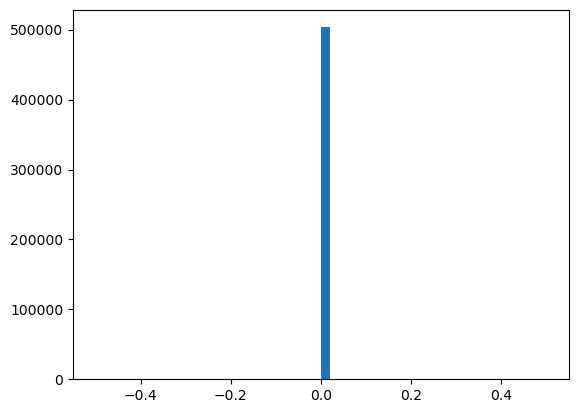

In [479]:
plt.hist(np.nan_to_num(dnbr.to_numpy().flatten()), bins=50)
plt.show()

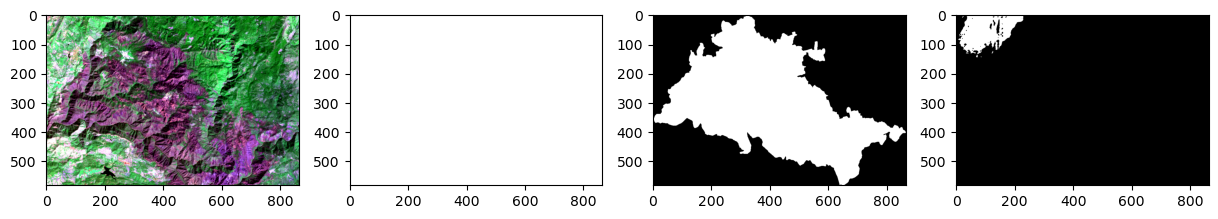

In [480]:
# plt.figure(figsize=(10,10))
fig, axs = plt.subplots(1, 4, figsize=(15, 7))

axs[0].imshow(image)
k = 5
# bottom_points, top_points = sample_top_k_percent(dnbr.to_numpy(), k)
input_points = np.concatenate([bottom_points, top_points], axis=0)
input_labels = np.array([0] * k + [1] * k)
# show_points(input_points, input_labels, axs[0])

# dnbr.plot.imshow(ax=axs[1])
axs[1].imshow(dnbr, cmap='RdBu_r')

# Mask
mask = np.load(files_mask[region])
axs[2].imshow(mask, cmap='gray')

# pred
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)
highest_score_index = scores.argmax()
pred_mask = masks[highest_score_index]
axs[3].imshow(pred_mask, cmap='gray')

# print(list(accs.values())[i], list(IoUs.values())[i], scores)
plt.show()

In [15]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/lfs/turing3/0/kaif/checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda:2"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)

In [16]:
num_gpus = torch.cuda.device_count()
print("Number of available GPUs: ", num_gpus)

# Get the name of all CUDA devices
for i in range(num_gpus):
    print("Device {}: {}".format(i, torch.cuda.get_device_name(i)))

Number of available GPUs:  10
Device 0: NVIDIA GeForce RTX 2080 Ti
Device 1: NVIDIA GeForce RTX 2080 Ti
Device 2: NVIDIA GeForce RTX 2080 Ti
Device 3: NVIDIA GeForce RTX 2080 Ti
Device 4: NVIDIA GeForce RTX 2080 Ti
Device 5: NVIDIA GeForce RTX 2080 Ti
Device 6: NVIDIA GeForce RTX 2080 Ti
Device 7: NVIDIA GeForce RTX 2080 Ti
Device 8: NVIDIA GeForce RTX 2080 Ti
Device 9: NVIDIA GeForce RTX 2080 Ti


In [37]:
# masks = mask_generator.generate(image)

predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

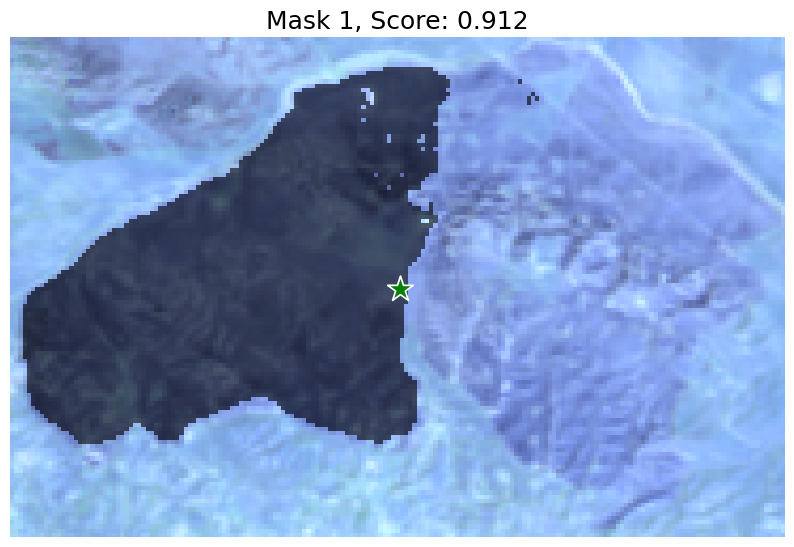

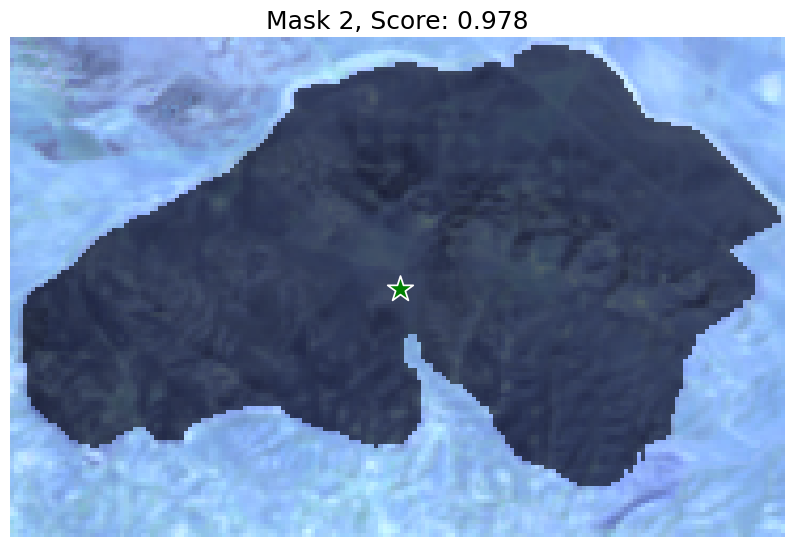

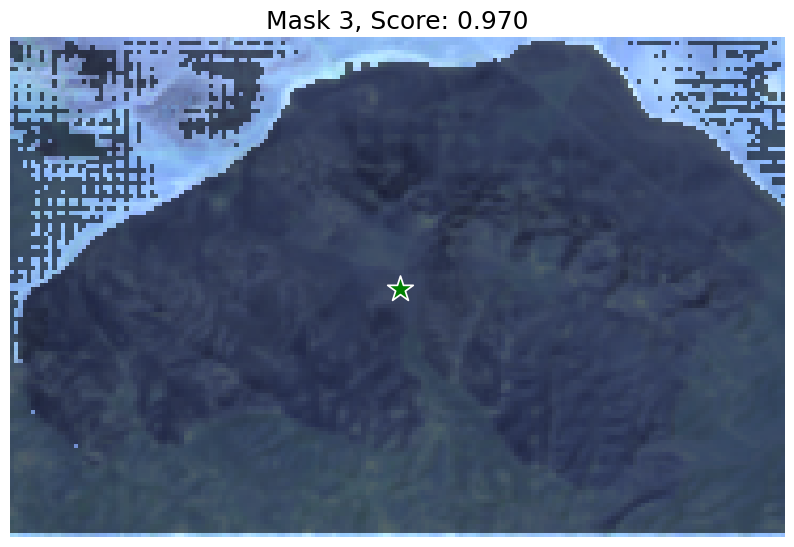

In [38]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

In [43]:
def IoU(pred, target):
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    return np.sum(intersection) / np.sum(union)

def pixel_accuracy(pred, target):
    return np.mean(pred == target)

In [491]:
IoUs = {}
accs = {}

from einops import pack, unpack
from tqdm import tqdm

bad_regions = {'CA4090112136820140731', 'CA3791712013219870831'}

for region in tqdm(regions):
    # with rasterio.open(files_post[region]) as src:
    #     ds_post = src.read()

    # with rasterio.open(files_pre[region]) as src:
    #     ds_pre = src.read()
    if region in bad_regions:
        continue

    ds_post = xr.open_dataset(files_post[region]).to_array().squeeze().transpose('y', 'x', 'band')
    ds_pre = xr.open_dataset(files_pre[region]).to_array().squeeze().transpose('y', 'x', 'band')
    
    image = ds_post
    
    dnbr = calculate_dnbr(ds_pre, ds_post, apply_qa_bitmask=False)

    image, _ = pack([image.to_numpy(), dnbr.to_numpy()], 'x y *')
    
    image = rescale_imshow_rgb(image)
    
    channels = [3, 4, 6]
    # channels = [2, 1, 0]
    image = image[:, :, channels]

    k = 5
    bottom_points, top_points = sample_top_k_percent(dnbr.to_numpy(), k)

    if len(bottom_points) < 5:
        print(region)
        continue
    
    input_points = np.concatenate([bottom_points, top_points], axis=0)
    input_labels = np.array([0] * k + [1] * k)
    
    predictor.set_image(image)
    pred_masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        multimask_output=True,
    )

    highest_score_index = scores.argmax()
    pred_mask = pred_masks[highest_score_index]
    
    true_mask = np.load(files_mask[region])

    IoUs[region] = IoU(pred_mask, true_mask)
    accs[region] = pixel_accuracy(pred_mask, true_mask)

 80%|███████████████████████████████████████          | 1267/1590 [18:11<04:29,  1.20it/s]/lfs/turing3/0/kaif/miniforge3/envs/burned/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/lfs/turing3/0/kaif/miniforge3/envs/burned/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
 80%|███████████████████████████████████████          | 1268/1590 [18:15<09:16,  1.73s/it]

CA3742412156820200816


 94%|██████████████████████████████████████████████▎  | 1502/1590 [21:44<01:14,  1.18it/s]/lfs/turing3/0/kaif/miniforge3/envs/burned/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/lfs/turing3/0/kaif/miniforge3/envs/burned/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


CA3256911672719951128


100%|█████████████████████████████████████████████████| 1590/1590 [22:57<00:00,  1.15it/s]


In [493]:
iou = np.array(list(IoUs.values()))
np.mean(iou)

0.4330055110894313

In [246]:
iou = np.array(list(accs.values()))
np.mean(iou)

0.7154533445680448

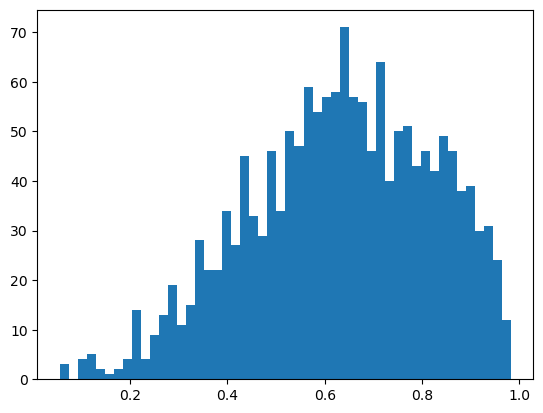

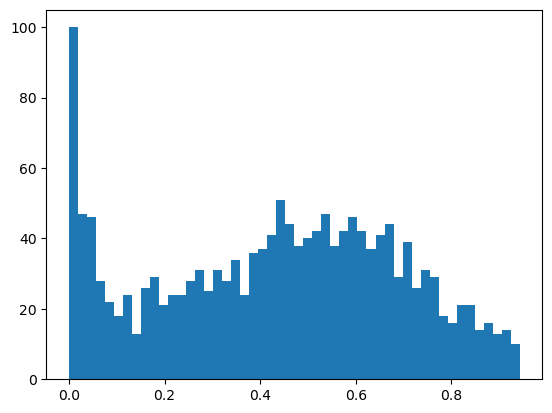

In [494]:
plt.hist(list(accs.values()), bins=50)
plt.show()

plt.hist(list(IoUs.values()), bins=50)
plt.show()

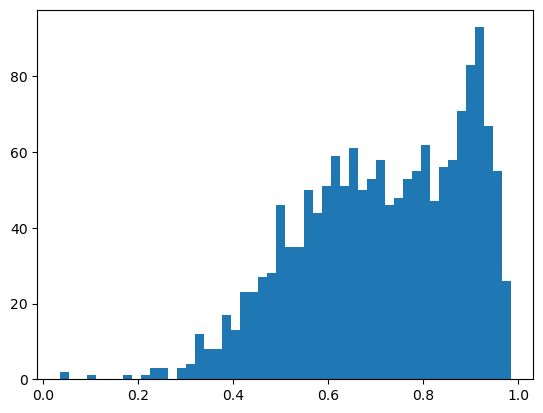

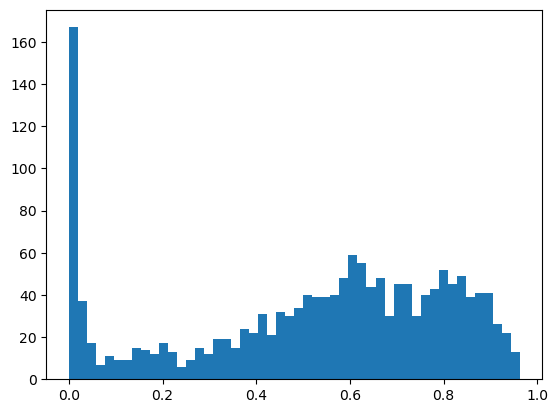

In [247]:
plt.hist(list(accs.values()), bins=50)
plt.show()

plt.hist(list(IoUs.values()), bins=50)
plt.show()

In [216]:
for i, x in enumerate(IoUs.values()):
    if x == 0:
        print(i, x)
        break

89 0.0


In [28]:
print(len(masks))
print(masks[0].keys())

8
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [16]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 76377,
 'bbox': [0, 223, 422, 309],
 'predicted_iou': 1.0341999530792236,
 'point_coords': [[362.5, 258.65625]],
 'stability_score': 0.9911314249038696,
 'crop_box': [0, 0, 800, 534]}

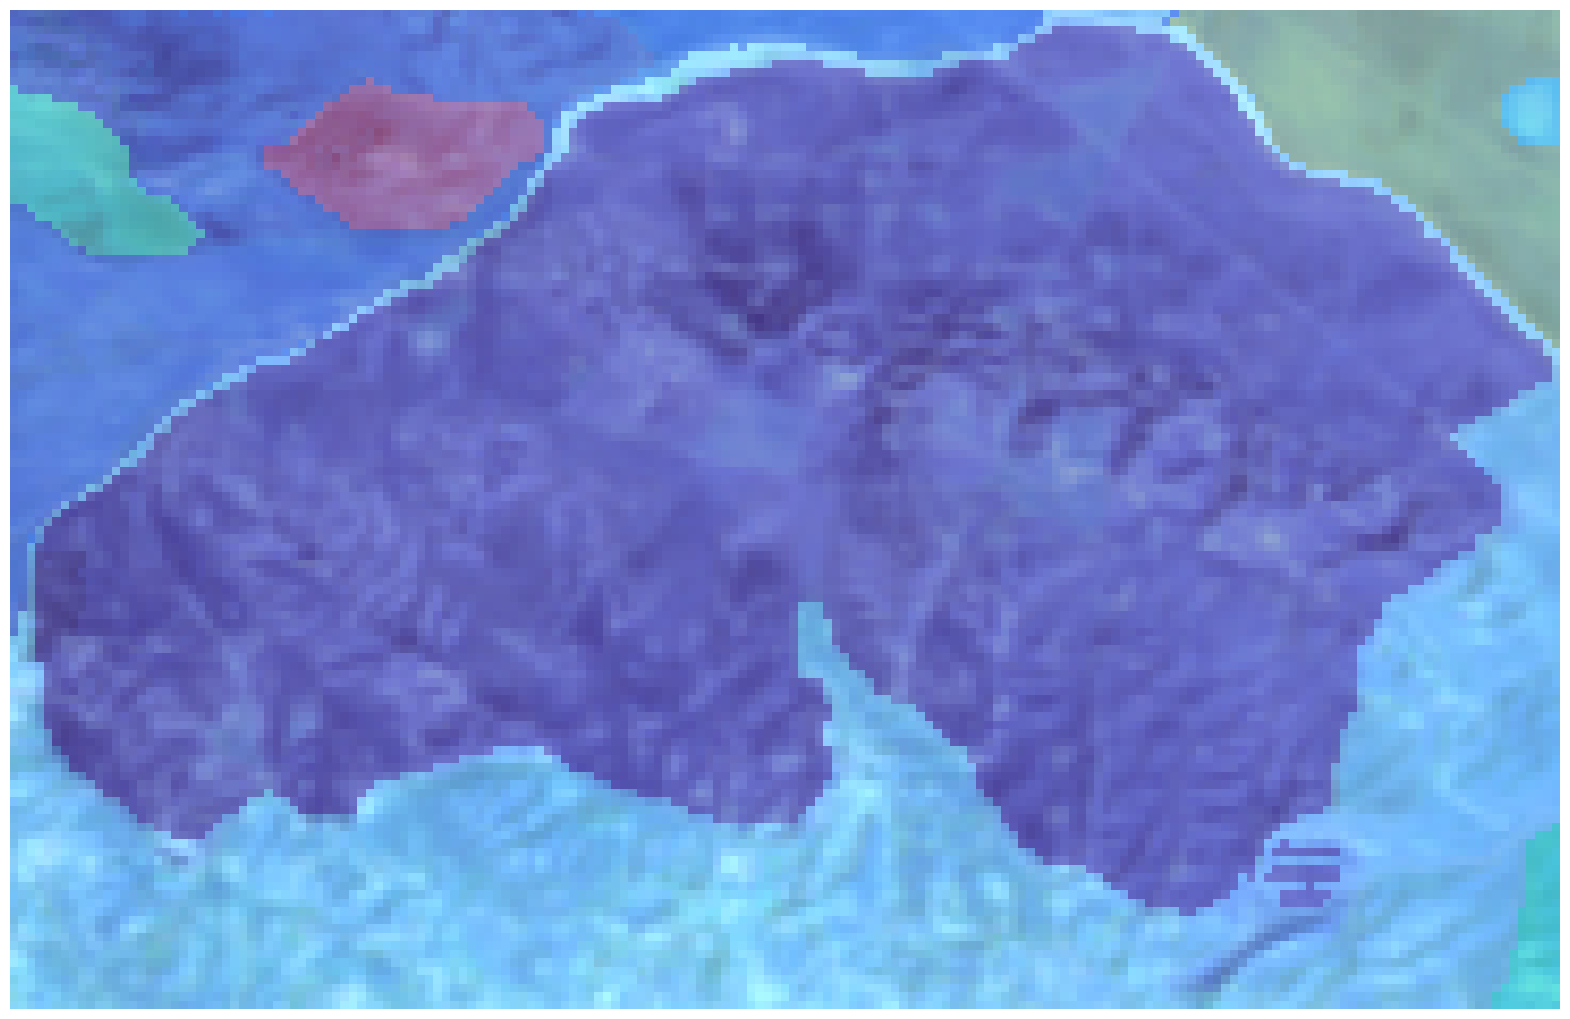

In [37]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [33]:
import numpy as np
im = np.load(f'/lfs/turing3/0/kaif/data/processed/masks/CA3257311670020190814.npy')
im

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

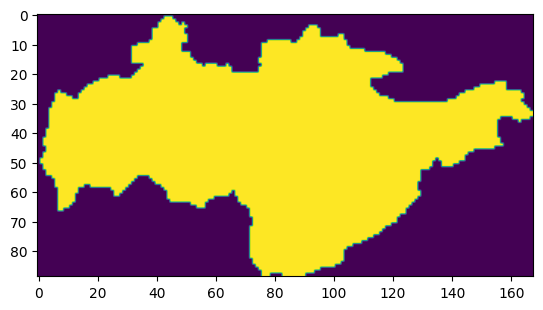

In [34]:
plt.imshow(im)